In [ ]:

!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 67.3 MB/s eta 0:00:00


In [ ]:

import rasterio
import matplotlib.pyplot as plt

# Load the georeferenced image
image_path = "/content/Naguabo_180706537_FSTopo.tiff"
with rasterio.open(image_path) as src:
    image = src.read(1)
    crs = src.crs
    bounds = src.bounds


In [ ]:
from pyproj import Transformer

# Define coordinate transformation
transformer = Transformer.from_crs("EPSG:4326", crs.to_string(), always_xy=True)  # WGS84 to image CRS
x, y = transformer.transform(-65.6985, 18.1970)


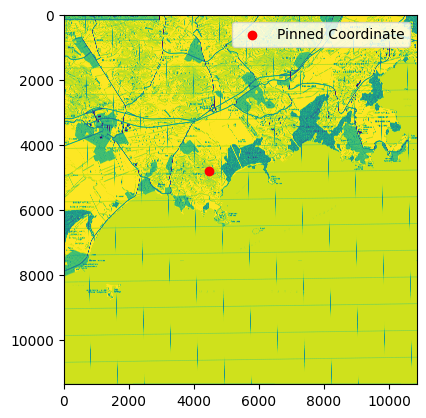

In [ ]:
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Convert coordinates to image pixel location
row, col = src.index(x, y)  # Convert to pixel indices

# Plot image with point
plt.imshow(image)

plt.scatter(col, row, color='red', label='Pinned Coordinate')
plt.legend()
plt.show()


In [ ]:
with rasterio.open(image_path) as src:
    row, col = src.index(x, y)
    print(f"Pixel location: row={row}, col={col}")


Pixel location: row=4815, col=4471


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pyproj
from affine import Affine
from typing import Tuple, Optional

class GeospatialColorPredictor:
    def __init__(self,
                 pixel_location: Tuple[int, int],
                 coordinates: Tuple[float, float],
                 min_value: float = 0,
                 max_value: float = 100,
                 raster_transform: Optional[Affine] = None):
        """
        Initialize GeospatialColorPredictor with pixel details and color mapping.

        Args:
            pixel_location (Tuple[int, int]): (row, column) of the pixel
            coordinates (Tuple[float, float]): (longitude, latitude) of the point
            min_value (float): Minimum value for color scaling
            max_value (float): Maximum value for color scaling
            raster_transform (Affine, optional): Raster transformation matrix
        """
        self.row, self.col = pixel_location
        self.longitude, self.latitude = coordinates
        self.min_value = min_value
        self.max_value = max_value

        # Coordinate Reference System setup
        self.wgs84 = pyproj.CRS.from_epsg(4326)
        self.utm = pyproj.CRS.from_epsg(32633)
        self.transformer = pyproj.Transformer.from_crs(
            self.wgs84, self.utm, always_xy=True
        )

        # Raster transform (default to identity if not provided)
        self.raster_transform = raster_transform or Affine.identity

        # Color mapping
        self.color_map = plt.cm.Blues

    def _normalize_value(self, value: float) -> float:
        """
        Normalize the input value to a range between 0 and 1.

        Args:
            value (float): Input value to normalize

        Returns:
            float: Normalized value between 0 and 1
        """
        return (value - self.min_value) / (self.max_value - self.min_value)

    def predict_color(self, value: float) -> Tuple[float, float, float, float]:
        """
        Predict the RGBA color for a given value.

        Args:
            value (float): Value to map to color

        Returns:
            Tuple of RGBA color values
        """
        # Clamp value to defined range
        clamped_value = max(min(value, self.max_value), self.min_value)
        normalized_value = self._normalize_value(clamped_value)
        return self.color_map(normalized_value)

    def generate_color_analysis(self) -> dict:
        """
        Generate comprehensive color and geospatial analysis.

        Returns:
            dict: Detailed analysis including color prediction
        """
        # Convert coordinates to UTM
        easting, northing = self.transformer.transform(
            self.longitude, self.latitude
        )

        # Calculate a sample value (for demonstration, using easting as an example)
        sample_value = easting % (self.max_value - self.min_value) + self.min_value

        # Predict color
        color_rgba = self.predict_color(sample_value)

        return {
            "Pixel Location": {
                "Row": self.row,
                "Column": self.col
            },
            "Coordinates": {
                "Longitude": self.longitude,
                "Latitude": self.latitude,
                "UTM Easting": easting,
                "UTM Northing": northing
            },
            "Color Prediction": {
                "Sample Value": sample_value,
                "Color (RGBA)": color_rgba,
                "Hex Color": self._rgba_to_hex(color_rgba)
            }
        }

    def _rgba_to_hex(self, rgba: Tuple[float, float, float, float]) -> str:
        """
        Convert RGBA color to hex color code.

        Args:
            rgba (Tuple[float, float, float, float]): RGBA color values

        Returns:
            str: Hex color code
        """
        # Convert RGB to 0-255 range and ignore alpha
        r, g, b= [int(x * 255) for x in rgba[:3]]
        return f'#{r:02x}{g:02x}{b:02x}'

    def visualize_color_gradient(self, num_ticks: int = 5) -> plt.Figure:
        """
        Generate a color gradient legend.

        Args:
            num_ticks (int): Number of ticks to show on the legend

        Returns:
            matplotlib Figure object
        """
        fig, ax = plt.subplots(figsize=(3, 6))

        # Create gradient
        gradient = np.linspace(0, 1, 256).reshape(1, -1)
        ax.imshow(gradient, aspect='auto', cmap=self.color_map)

        # Set ticks and labels
        tick_positions = np.linspace(0, 255, num_ticks)
        tick_values = np.linspace(self.min_value, self.max_value, num_ticks)

        ax.set_yticks(tick_positions)
        ax.set_yticklabels([f'{val:.2f}' for val in tick_values])

        ax.set_title('Color Gradient Legend')
        ax.set_xlabel('Color Intensity')
        ax.set_ylabel('Value')

        return fig



In [ ]:
predictor = GeospatialColorPredictor(
        pixel_location=(4815, 4471),
        coordinates=(-65.6985, 18.1970),
        min_value=0,
        max_value=6000
    )

In [ ]:
analysis = predictor.generate_color_analysis()

In [ ]:
import json
print(json.dumps(analysis, indent=2))

{
  "Pixel Location": {
    "Row": 4815,
    "Column": 4471
  },
  "Coordinates": {
    "Longitude": -65.6985,
    "Latitude": 18.197,
    "UTM Easting": -10409505.591821395,
    "UTM Northing": 7136615.820451794
  },
  "Color Prediction": {
    "Sample Value": 494.40817860513926,
    "Color (RGBA)": [
      0.9040369088811996,
      0.9429757785467128,
      0.9793310265282583,
      1.0
    ],
    "Hex Color": "#e6f0f9"
  }
}
